In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import time

# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

Libraries imported - ready to use PyTorch 2.4.1+cu121


In [ ]:
from matplotlib import pyplot as plt
def show_image(image, label):
    image = image.permute(1, 2, 0)
    plt.imshow(image.squeeze())
    plt.title(f'Label: {label}')
    plt.show()

In [3]:
class Params:
    def __init__(self):
        self.batch_size = 16
        self.name = "resnet_50"
        self.workers = 4
        self.lr = 0.1
        self.momentum = 0.9
        self.weight_decay = 1e-4
        self.lr_step_size = 30
        self.lr_gamma = 0.1

    def __repr__(self):
        return str(self.__dict__)

    def __eq__(self, other):
        return self.__dict__ == other.__dict__

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

params = Params()

print(f"Using {device} device")
print(params.lr, params.batch_size)

Using cuda device


({'batch_size': 16, 'name': 'resnet_152_sgd1', 'workers': 4, 'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_step_size': 30, 'lr_gamma': 0.1},
 16)

In [4]:
training_folder_name = '/mnt/dataEBS/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train'
val_folder_name = '/mnt/dataEBS/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val'
test_folder_name = '/mnt/dataEBS/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/test'


torch.Size([16, 3, 224, 224])


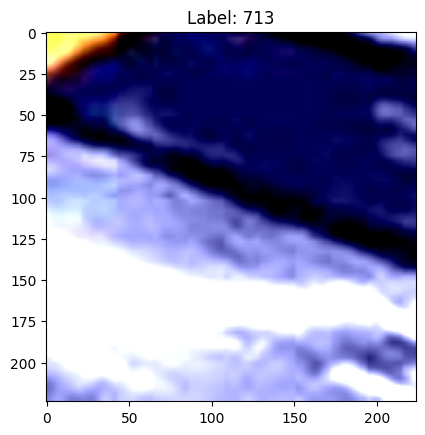

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np

class AlbumentationsWrapper(object):
       def __init__(self, albumentation):
           self.albumentation = albumentation

       def __call__(self, img):
           # Assuming you're working with PIL images
           img = np.array(img)  # Convert PIL image to NumPy array
           augmented = self.albumentation(image=img)
           return Image.fromarray(augmented['image'])  # Convert back to PIL image

train_transformation = transforms.Compose([
        transforms.RandomResizedCrop(224, interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(10),
        AlbumentationsWrapper(A.CoarseDropout(max_holes=1, max_height=24, max_width=24, min_holes=1, min_height=8, min_width=8, fill_value=1, mask_fill_value=None, always_apply=False, p=0.25)),
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = torchvision.datasets.ImageFolder(
    root=training_folder_name,
    transform=train_transformation
)
train_sampler = torch.utils.data.RandomSampler(train_dataset)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=params.batch_size,
    sampler=train_sampler,
    num_workers = params.workers,
    pin_memory=True,
)
for X, y in train_loader:
    break
print(X.shape)
show_image(X[0], y[0])

torch.Size([64, 3, 224, 224])


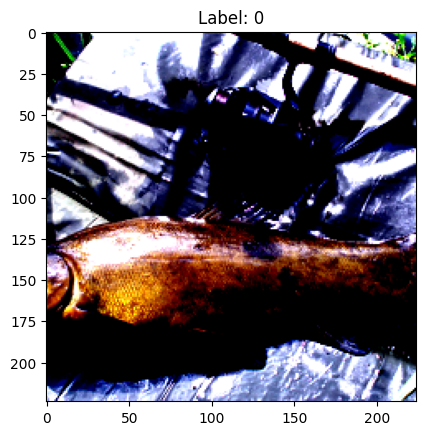

In [7]:
val_transformation = transforms.Compose([
        transforms.Resize(size=256, antialias=True),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
val_dataset = torchvision.datasets.ImageFolder(
    root=val_folder_name,
    transform=val_transformation
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=64,
    num_workers=params.workers,
    shuffle=False,
    pin_memory=True
)
for X, y in val_loader:
    break
print(X.shape)
show_image(X[0], y[0])

In [8]:
from math import sqrt
def train(dataloader, model, loss_fn, optimizer, epoch, writer):
    size = len(dataloader.dataset)
    model.train()
    start0 = time.time()
    start = time.time()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        batch_size = len(X)
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}], {(current/size * 100):>4f}%")
            step = epoch * size + current
            writer.add_scalar('training loss',
                            loss,
                            step)
            new_start = time.time()
            delta = new_start - start
            start = new_start
            if batch != 0:
                print("Done in ", delta, " seconds")
                remaining_steps = size - current
                speed = 100 * batch_size / delta
                remaining_time = remaining_steps / speed
                print("Remaining time (seconds): ", remaining_time)
        optimizer.zero_grad()
    print("Entire epoch done in ", time.time() - start0, " seconds")

In [9]:
def test(dataloader, model, loss_fn, epoch, writer, train_dataloader, calc_acc5=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct, correct_top5 = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            if calc_acc5:
                _, pred_top5 = pred.topk(5, 1, largest=True, sorted=True)
                correct_top5 += pred_top5.eq(y.view(-1, 1).expand_as(pred_top5)).sum().item()
    test_loss /= num_batches
    step = epoch * len(train_dataloader.dataset)
    if writer != None:
        writer.add_scalar('test loss',
                            test_loss,
                            step)
    correct /= size
    correct_top5 /= size
    if writer != None:
        writer.add_scalar('test accuracy',
                            100*correct,
                            step)
        if calc_acc5:
            writer.add_scalar('test accuracy5',
                            100*correct_top5,
                            step)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if calc_acc5:
        print(f"Test Error: \n Accuracy-5: {(100*correct_top5):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
## testing a pretrained model to validate correctness of our dataset, transform and metrics code
# pretrained_model = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT').to(device)
# start = time.time()
# loss_fn = nn.CrossEntropyLoss()
# test(val_loader, pretrained_model, loss_fn, epoch=0, writer=None, train_dataloader=train_loader, calc_acc5=True)
# print("Elapsed: ", time.time() - start)

In [15]:
from torchvision import models

def get_resnet50_model():
    model = models.resnet50(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 1000)
    return model

model = get_resnet50_model()

device = "cuda"
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=params.lr, momentum=params.momentum, weight_decay=params.weight_decay)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=params.lr_step_size, gamma=params.lr_gamma)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=params.lr * 8,  # More moderate multiplier
                total_steps=(len(train_dataset) // params.batch_size) * params.num_epochs,
                pct_start=0.2,  # Longer warmup for stability
                anneal_strategy='cos',
                div_factor=15,
                final_div_factor=500,
                three_phase=True
            )

In [ ]:
# resume training options
resume_training = False
start_epoch = 0

In [ ]:
checkpoint_path = os.path.join("/mnt/checkpoints", params.name, f"checkpoint.pth")
if resume_training and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model"])
    start_epoch = checkpoint["epoch"] + 1
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])
    assert params == checkpoint["params"]

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path

Path(os.path.join("checkpoints", params.name)).mkdir(parents=True, exist_ok=True)
writer = SummaryWriter('runs/' + params.name)

test(val_loader, model, loss_fn, epoch=0, writer=writer, train_dataloader=train_loader, calc_acc5=True)


start_epoch = 0
for epoch in range(start_epoch, 100):
    train(train_loader, model, loss_fn, optimizer, epoch=epoch, writer=writer)
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "lr_scheduler": lr_scheduler.state_dict(),
        "epoch": epoch,
        "params": params
    }
    torch.save(checkpoint, os.path.join("checkpoints", params.name, f"model_{epoch}.pth"))
    torch.save(checkpoint, os.path.join("checkpoints", params.name, f"checkpoint.pth"))
    lr_scheduler.step()
    test(val_loader, model, loss_fn, epoch + 1, writer, train_dataloader=train_loader, calc_acc5=True)